In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from dataset import train_dataloader, test_dataloader
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda")

In [3]:
ngf = 64
ndf = 64
nc = 3
lr = 1
beta1 = 0.5

In [4]:
#DCGAN
from network import GeneratorSkip, Discriminator,BasicBlock, weights_init

netG = GeneratorSkip(ngf,nc,BasicBlock).to(device)
netG.apply(weights_init)
netD = Discriminator(ndf,nc).to(device)
netD.apply(weights_init)

criterion = nn.BCELoss()
mse = nn.MSELoss()
def lr_schedule(epoch):
    lr = 0
    if(epoch < 8):
        lr = 0.001 * ((epoch+1)/8)
    else:
        lr = 0.001*(8/epoch)
    return lr

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
DScheduler = torch.optim.lr_scheduler.LambdaLR(optimizerD, lr_schedule)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
GScheduler = torch.optim.lr_scheduler.LambdaLR(optimizerG, lr_schedule)

In [5]:
# Training Loop
real_label = 1.0
fake_label = 0.0
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
MSE_losses = []
test_MSE_losses = []
iters = 0
num_epochs = 30
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data["nor"].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = data["diff"].to(device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = (criterion(output, label)  + mse(fake,real_cpu))/2
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        MSE_losses.append(mse(fake,real_cpu).item())
        loss_fn = nn.MSELoss()
        data_test = next(iter(test_dataloader))
        fake_test = netG(data_test["diff"].to(device)).detach().cpu()
        test_MSE_losses.append(mse(fake_test,data_test["nor"]))
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tMSE_LossG: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(train_dataloader),
                        errD.item(), errG.item(), mse(fake,real_cpu).item(), D_x, D_G_z1, D_G_z2))
            print("TEST MSE: ", test_MSE_losses[-1])


        
        # Check how the generator is doing by saving G's output on fixed_noise
#         if iters % 10 == 0:
#             with torch.no_grad():
#                 loss_fn = nn.MSELoss()
#                 data = next(iter(test_dataloader))
#                 fake = netG(data["diff"].to(device)).detach().cpu()
#                 test_MSE_losses.append(mse(fake,data["nor"]))
#                 print("TEST MSE: ", mse(fake,data["nor"]))
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

#         iters += 1
    DScheduler.step()
    GScheduler.step()

Starting Training Loop...
[0/30][0/5]	Loss_D: 2.0150	Loss_G: 0.0691	MSE_LossG: 0.0778	D(x): 0.1926	D(G(z)): 0.2158 / 0.9426
TEST MSE:  tensor(0.0692)
[1/30][0/5]	Loss_D: 0.6839	Loss_G: 2.9912	MSE_LossG: 0.0596	D(x): 0.9627	D(G(z)): 0.4397 / 0.0039
TEST MSE:  tensor(0.0548)
[2/30][0/5]	Loss_D: 0.4908	Loss_G: 3.3183	MSE_LossG: 0.0406	D(x): 0.7948	D(G(z)): 0.1224 / 0.0052
TEST MSE:  tensor(0.0415)
[3/30][0/5]	Loss_D: 1.4581	Loss_G: 3.7907	MSE_LossG: 0.0390	D(x): 1.0000	D(G(z)): 0.7467 / 0.0009
TEST MSE:  tensor(0.0295)
[4/30][0/5]	Loss_D: 2.6905	Loss_G: 3.8511	MSE_LossG: 0.0224	D(x): 1.0000	D(G(z)): 0.8985 / 0.0291
TEST MSE:  tensor(0.0200)
[5/30][0/5]	Loss_D: 0.3258	Loss_G: 2.2888	MSE_LossG: 0.0268	D(x): 0.8559	D(G(z)): 0.0689 / 0.0138
TEST MSE:  tensor(0.0248)
[6/30][0/5]	Loss_D: 2.0840	Loss_G: 2.2632	MSE_LossG: 0.0125	D(x): 0.9990	D(G(z)): 0.7823 / 0.0584
TEST MSE:  tensor(0.0161)
[7/30][0/5]	Loss_D: 0.3360	Loss_G: 2.5848	MSE_LossG: 0.0113	D(x): 0.7676	D(G(z)): 0.0086 / 0.0383
TEST MSE

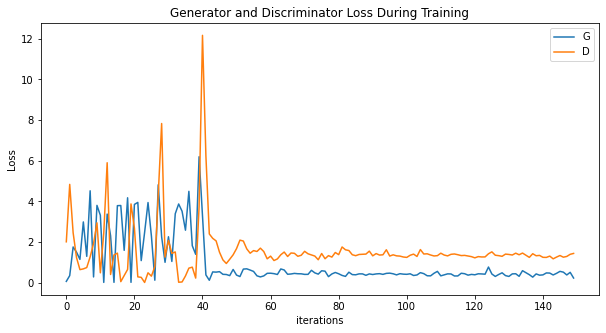

In [6]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

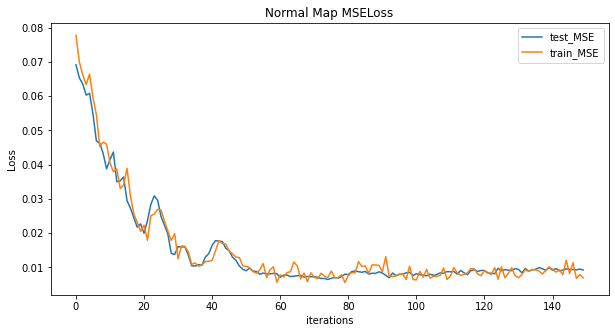

In [7]:
plt.figure(figsize=(10,5))
plt.title("Normal Map MSELoss")
plt.plot(test_MSE_losses,label="test_MSE")
plt.plot(MSE_losses,label="train_MSE")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [8]:
normal_map_mse = test_MSE_losses.copy()

In [11]:
lr

1

In [12]:
#DCGAN - Disp
from network import GeneratorSkip, Discriminator,BasicBlock, weights_init

netG = GeneratorSkip(ngf,1,BasicBlock).to(device)
netG.apply(weights_init)
netD = Discriminator(ndf,1).to(device)
netD.apply(weights_init)

criterion = nn.BCELoss()
mse = nn.MSELoss()
def lr_schedule(epoch):
    lr = 0
    if(epoch < 8):
        lr = 0.001 * ((epoch+1)/8)
    else:
        lr = 0.001*(8/epoch)
    return lr

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
DScheduler = torch.optim.lr_scheduler.LambdaLR(optimizerD, lr_schedule)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
GScheduler = torch.optim.lr_scheduler.LambdaLR(optimizerG, lr_schedule)

In [13]:
target = "disp"
# Training Loop
real_label = 1.0
fake_label = 0.0
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
MSE_losses = []
test_MSE_losses = []
iters = 0
num_epochs = 30
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[target].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = data["diff"].to(device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = (criterion(output, label)  + mse(fake,real_cpu))/2
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        MSE_losses.append(mse(fake,real_cpu).item())
        loss_fn = nn.MSELoss()
        data_test = next(iter(test_dataloader))
        fake_test = netG(data_test["diff"].to(device)).detach().cpu()
        test_MSE_losses.append(mse(fake_test,data_test[target]))
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tMSE_LossG: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(train_dataloader),
                        errD.item(), errG.item(), mse(fake,real_cpu).item(), D_x, D_G_z1, D_G_z2))
            print("TEST MSE: ", test_MSE_losses[-1])


        
        # Check how the generator is doing by saving G's output on fixed_noise
#         if iters % 10 == 0:
#             with torch.no_grad():
#                 loss_fn = nn.MSELoss()
#                 data = next(iter(test_dataloader))
#                 fake = netG(data["diff"].to(device)).detach().cpu()
#                 test_MSE_losses.append(mse(fake,data["nor"]))
#                 print("TEST MSE: ", mse(fake,data["nor"]))
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

#         iters += 1
    DScheduler.step()
    GScheduler.step()

Starting Training Loop...
[0/30][0/5]	Loss_D: 1.1305	Loss_G: 2.9765	MSE_LossG: 0.0881	D(x): 0.7353	D(G(z)): 0.5095 / 0.0034
TEST MSE:  tensor(0.1108)
[1/30][0/5]	Loss_D: 2.4127	Loss_G: 1.8470	MSE_LossG: 0.1254	D(x): 0.5140	D(G(z)): 0.3846 / 0.3701
TEST MSE:  tensor(0.1342)
[2/30][0/5]	Loss_D: 1.5410	Loss_G: 1.8809	MSE_LossG: 0.1189	D(x): 0.7288	D(G(z)): 0.5679 / 0.1922
TEST MSE:  tensor(0.1321)
[3/30][0/5]	Loss_D: 1.5199	Loss_G: 1.0599	MSE_LossG: 0.1064	D(x): 0.6309	D(G(z)): 0.5932 / 0.1630
TEST MSE:  tensor(0.1192)
[4/30][0/5]	Loss_D: 1.9966	Loss_G: 1.0772	MSE_LossG: 0.0929	D(x): 0.5119	D(G(z)): 0.5191 / 0.3773
TEST MSE:  tensor(0.0915)
[5/30][0/5]	Loss_D: 1.6670	Loss_G: 0.4427	MSE_LossG: 0.1359	D(x): 0.3918	D(G(z)): 0.4485 / 0.5125
TEST MSE:  tensor(0.1300)
[6/30][0/5]	Loss_D: 1.6667	Loss_G: 0.6894	MSE_LossG: 0.0862	D(x): 0.6311	D(G(z)): 0.5532 / 0.4200
TEST MSE:  tensor(0.1245)
[7/30][0/5]	Loss_D: 2.4509	Loss_G: 0.6864	MSE_LossG: 0.1211	D(x): 0.5286	D(G(z)): 0.4487 / 0.4365
TEST MSE

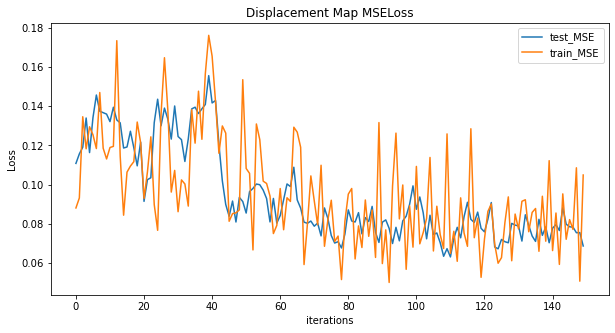

In [14]:
plt.figure(figsize=(10,5))
plt.title("Displacement Map MSELoss")
plt.plot(test_MSE_losses,label="test_MSE")
plt.plot(MSE_losses,label="train_MSE")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
disp_map_mse = test_MSE_losses.copy()

In [16]:
#DCGAN - Disp
from network import GeneratorSkip, Discriminator,BasicBlock, weights_init

netG = GeneratorSkip(ngf,1,BasicBlock).to(device)
netG.apply(weights_init)
netD = Discriminator(ndf,1).to(device)
netD.apply(weights_init)

criterion = nn.BCELoss()
mse = nn.MSELoss()
def lr_schedule(epoch):
    lr = 0
    if(epoch < 8):
        lr = 0.001 * ((epoch+1)/8)
    else:
        lr = 0.001*(8/epoch)
    return lr

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
DScheduler = torch.optim.lr_scheduler.LambdaLR(optimizerD, lr_schedule)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
GScheduler = torch.optim.lr_scheduler.LambdaLR(optimizerG, lr_schedule)

In [17]:
target = "rough"
# Training Loop
real_label = 1.0
fake_label = 0.0
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
MSE_losses = []
test_MSE_losses = []
iters = 0
num_epochs = 30
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[target].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = data["diff"].to(device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = (criterion(output, label)  + mse(fake,real_cpu))/2
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        MSE_losses.append(mse(fake,real_cpu).item())
        loss_fn = nn.MSELoss()
        data_test = next(iter(test_dataloader))
        fake_test = netG(data_test["diff"].to(device)).detach().cpu()
        test_MSE_losses.append(mse(fake_test,data_test[target]))
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tMSE_LossG: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(train_dataloader),
                        errD.item(), errG.item(), mse(fake,real_cpu).item(), D_x, D_G_z1, D_G_z2))
            print("TEST MSE: ", test_MSE_losses[-1])


        
        # Check how the generator is doing by saving G's output on fixed_noise
#         if iters % 10 == 0:
#             with torch.no_grad():
#                 loss_fn = nn.MSELoss()
#                 data = next(iter(test_dataloader))
#                 fake = netG(data["diff"].to(device)).detach().cpu()
#                 test_MSE_losses.append(mse(fake,data["nor"]))
#                 print("TEST MSE: ", mse(fake,data["nor"]))
#             img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

#         iters += 1
    DScheduler.step()
    GScheduler.step()

Starting Training Loop...
[0/30][0/5]	Loss_D: 1.8209	Loss_G: 2.7342	MSE_LossG: 0.0780	D(x): 0.7134	D(G(z)): 0.7198 / 0.0148
TEST MSE:  tensor(0.0808)
[1/30][0/5]	Loss_D: 1.2976	Loss_G: 2.2684	MSE_LossG: 0.1055	D(x): 0.7645	D(G(z)): 0.5526 / 0.0169
TEST MSE:  tensor(0.0728)
[2/30][0/5]	Loss_D: 3.1107	Loss_G: 5.4837	MSE_LossG: 0.0529	D(x): 0.8899	D(G(z)): 0.9164 / 0.0000
TEST MSE:  tensor(0.0892)
[3/30][0/5]	Loss_D: 1.6901	Loss_G: 0.1557	MSE_LossG: 0.0817	D(x): 0.3729	D(G(z)): 0.3650 / 0.8067
TEST MSE:  tensor(0.0386)
[4/30][0/5]	Loss_D: 1.8629	Loss_G: 0.2797	MSE_LossG: 0.0512	D(x): 0.3491	D(G(z)): 0.3518 / 0.6215
TEST MSE:  tensor(0.0578)
[5/30][0/5]	Loss_D: 1.6432	Loss_G: 0.8985	MSE_LossG: 0.0652	D(x): 0.7487	D(G(z)): 0.7106 / 0.2177
TEST MSE:  tensor(0.0397)
[6/30][0/5]	Loss_D: 1.4630	Loss_G: 0.5007	MSE_LossG: 0.0697	D(x): 0.4335	D(G(z)): 0.4117 / 0.4854
TEST MSE:  tensor(0.0696)
[7/30][0/5]	Loss_D: 1.7988	Loss_G: 0.6213	MSE_LossG: 0.0561	D(x): 0.4268	D(G(z)): 0.3900 / 0.4659
TEST MSE

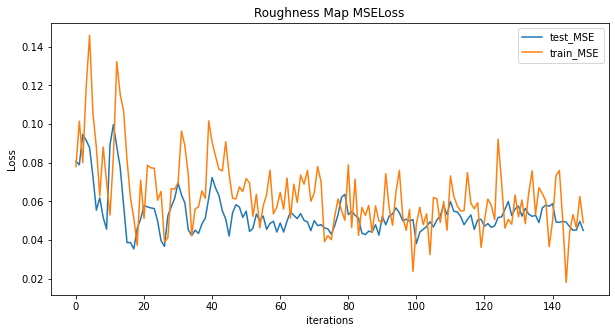

In [18]:
plt.figure(figsize=(10,5))
plt.title("Roughness Map MSELoss")
plt.plot(test_MSE_losses,label="test_MSE")
plt.plot(MSE_losses,label="train_MSE")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
rough_map_mse = test_MSE_losses.copy()

In [22]:
normal_map_mse

[tensor(0.0692),
 tensor(0.0654),
 tensor(0.0636),
 tensor(0.0603),
 tensor(0.0608),
 tensor(0.0548),
 tensor(0.0469),
 tensor(0.0463),
 tensor(0.0432),
 tensor(0.0388),
 tensor(0.0415),
 tensor(0.0437),
 tensor(0.0350),
 tensor(0.0353),
 tensor(0.0364),
 tensor(0.0295),
 tensor(0.0274),
 tensor(0.0245),
 tensor(0.0218),
 tensor(0.0227),
 tensor(0.0200),
 tensor(0.0236),
 tensor(0.0284),
 tensor(0.0309),
 tensor(0.0296),
 tensor(0.0248),
 tensor(0.0223),
 tensor(0.0198),
 tensor(0.0141),
 tensor(0.0138),
 tensor(0.0161),
 tensor(0.0160),
 tensor(0.0160),
 tensor(0.0136),
 tensor(0.0105),
 tensor(0.0104),
 tensor(0.0108),
 tensor(0.0106),
 tensor(0.0130),
 tensor(0.0140),
 tensor(0.0164),
 tensor(0.0178),
 tensor(0.0177),
 tensor(0.0176),
 tensor(0.0156),
 tensor(0.0149),
 tensor(0.0130),
 tensor(0.0121),
 tensor(0.0104),
 tensor(0.0095),
 tensor(0.0090),
 tensor(0.0098),
 tensor(0.0089),
 tensor(0.0088),
 tensor(0.0080),
 tensor(0.0084),
 tensor(0.0081),
 tensor(0.0081),
 tensor(0.0083

In [26]:
print(torch.min(torch.tensor(normal_map_mse)))
print(torch.min(torch.tensor(disp_map_mse)))
print(torch.min(torch.tensor(rough_map_mse)))

tensor(0.0065)
tensor(0.0631)
tensor(0.0354)


In [ ]:
#%%capture
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch= next(iter(test_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch["nor"].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-2],(1,2,0)))
plt.show()

In [ ]:
def multiloss(pred_concat, target_concat):
    torch.exp(torch.mean(torch.log(torch.mean(torch.square(pred_concat - target_concat), axis = 0)), axis = -1))

In [16]:
#DCGAN - Disp
from network import GeneratorSkipMultitask, Discriminator,BasicBlock, weights_init

netG = GeneratorSkip(ngf,1,BasicBlock).to(device)
netG.apply(weights_init)
netD = Discriminator(ndf,1).to(device)
netD.apply(weights_init)

criterion = nn.BCELoss()
mse = nn.MSELoss()
def lr_schedule(epoch):
    lr = 0
    if(epoch < 8):
        lr = 0.001 * ((epoch+1)/8)
    else:
        lr = 0.001*(8/epoch)
    return lr

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
DScheduler = torch.optim.lr_scheduler.LambdaLR(optimizerD, lr_schedule)
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
GScheduler = torch.optim.lr_scheduler.LambdaLR(optimizerG, lr_schedule)